## Image Classification: Dog or Cat

This notebook uses data from Kaggle's competition, Dogs vs Cats Redux: Kernels Edition, to predict whether an image is a dog or a cat. 

##### Dataset:
The train folder contains 25,000 images of dogs and cats. 
The test folder contains 12,500 images, named according to a numeric id.

##### Objective:
To predict the probability that each image in a test set is a dog (1 = dog, 0 = cat).

##### Process:
Two models will be compared. The best performing model will be used to make predictions on a test set. 

Model 1: CNN with no augmentation
Model 2: CNN with rotational and horizontal flip augmentation

##### Steps:

1. Import Libraries
2. Download & Read Kaggle date set, dogs-vs-cats-redux-kernels-edition
3. Explore Data
4. Build Model
5. Evaluate Model 1: CNN with No Augmentation
6. Evaluate Model 2: CNN with Augmentation
7. Predict Test Set

Data Source: https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/overview

### Import Libraries

In [19]:
import numpy as np
import pandas as pd

import os, glob, cv2, re
#!pip install kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

from collections import Counter

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Flatten, Conv2D, MaxPooling2D

In [2]:
!mkdir ~/.kaggle
!echo '{"username":"sherylmichael","key":"c75f8d530e0af74d13b7420065cc474b"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/sherilyn/.kaggle: File exists


### Download & Read Kaggle date set, dogs-vs-cats-redux-kernels-edition

In [3]:
#download Kaggle data set
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

api = KaggleApi()
api.authenticate()

api.competition_download_files('dogs-vs-cats-redux-kernels-edition')

In [4]:
zf = ZipFile('dogs-vs-cats-redux-kernels-edition.zip')
zf.extractall('data')
zf.close()

In [5]:
files = glob.glob('data/*.zip')
for file in files:
    print('Unzipping:',file)
    with ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('data/dogs_vs_cats')

Unzipping: data/test.zip
Unzipping: data/train.zip


In [3]:
#create directory of images (list)
train_images = glob.glob('data/dogs_vs_cats/train/*.jpg')
test_images = glob.glob('data/dogs_vs_cats/test/*.jpg')
print(type(train_images))
print('len(train_images): ', len(train_images), 'len(test_images) ', len(test_images))
train_images[0:5]

<class 'list'>
len(train_images):  25000 len(test_images)  12500


['data/dogs_vs_cats/train/dog.8011.jpg',
 'data/dogs_vs_cats/train/cat.5077.jpg',
 'data/dogs_vs_cats/train/dog.7322.jpg',
 'data/dogs_vs_cats/train/cat.2718.jpg',
 'data/dogs_vs_cats/train/cat.10151.jpg']

In [4]:
#create list of labels (dog=1, cat=0)
label=[1 if 'dog' in os.path.basename(os.path.normpath(path)) else 0 for path in train_images]
Counter(label)

Counter({1: 12500, 0: 12500})

### Explore Data

#### Visualizing Random Images

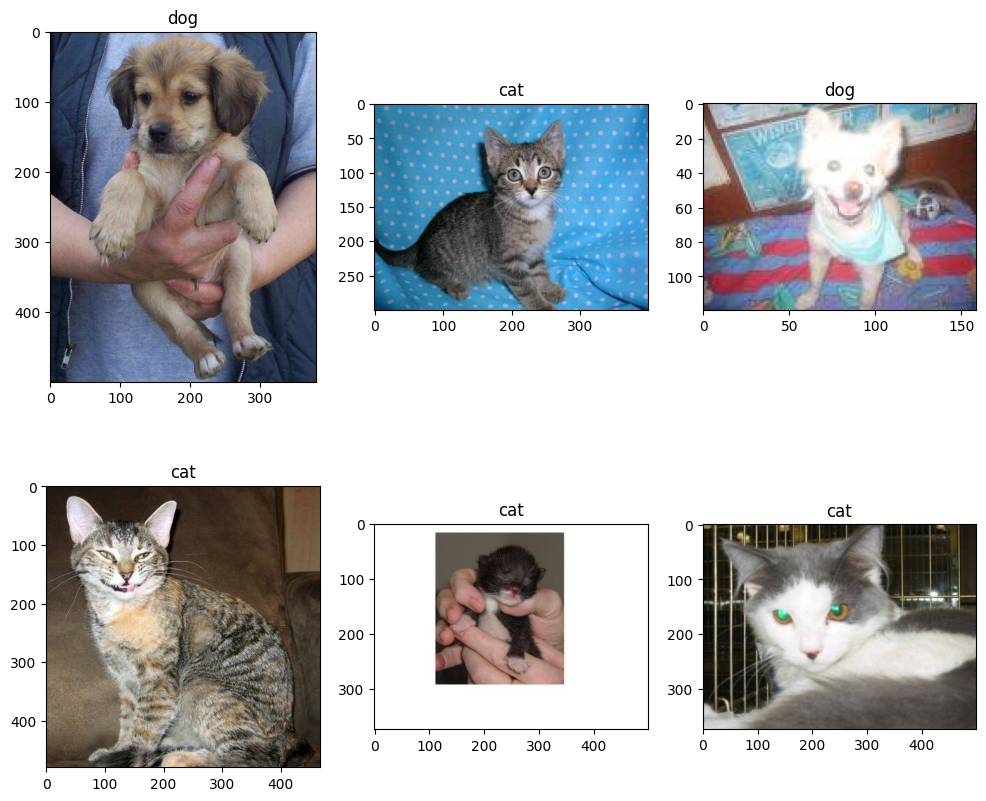

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

for image, ax in enumerate(axes.ravel()):
    img = Image.open(train_images[image])   
    ax.set_title(train_images[image].split('/')[-1].split('.')[0])
    ax.imshow(img)

##### Create DataFrames: train, test

In [6]:
#create df = train
train=pd.DataFrame(train_images)
train.head()
#rename df columns
train.rename(columns={0:'id'}, inplace=True)
#train.id = [os.path.basename(os.path.normpath(path)) for path in train_images]
#add label column
train['label'] = label
train['label'] = train['label'].astype(str)
print('train.shape: ', train.shape)
print(train.head())
#print(plt.imread(train['id'][10]).shape)

train.shape:  (25000, 2)
                                      id label
0   data/dogs_vs_cats/train/dog.8011.jpg     1
1   data/dogs_vs_cats/train/cat.5077.jpg     0
2   data/dogs_vs_cats/train/dog.7322.jpg     1
3   data/dogs_vs_cats/train/cat.2718.jpg     0
4  data/dogs_vs_cats/train/cat.10151.jpg     0


In [7]:
#create df = test
test=pd.DataFrame(test_images)
#rename df columns
test.rename(columns={0:'id'}, inplace=True)
#test.id = [os.path.basename(os.path.normpath(path)) for path in test_images]
print('test.shape: ', test.shape)
test.head()

test.shape:  (12500, 1)


,id
0,data/dogs_vs_cats/test/9733.jpg
1,data/dogs_vs_cats/test/63.jpg
2,data/dogs_vs_cats/test/6400.jpg
3,data/dogs_vs_cats/test/823.jpg
4,data/dogs_vs_cats/test/4217.jpg


#### Distribution of Dogs & Cats in train_images

Count of Unique Lables:  2
Unique labels:  ['1' '0']


Text(0, 0.5, 'Value Counts')

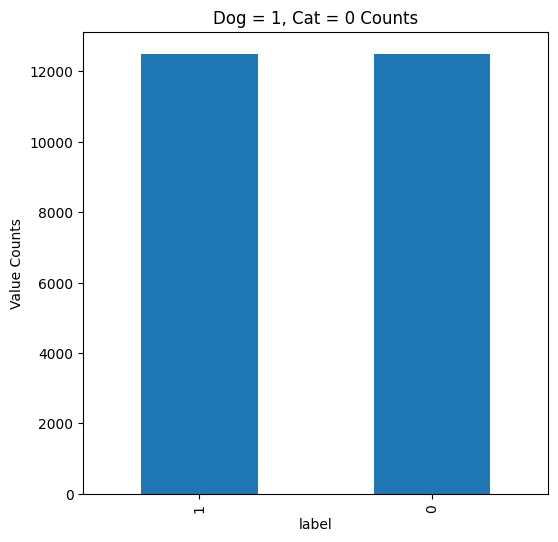

In [8]:
print('Count of Unique Lables: ', train.label.nunique())
print('Unique labels: ', train['label'].unique())
ax = train['label'].value_counts().plot(kind='bar', figsize=(6,6))
fig = ax.get_figure()
ax.set_title("Dog = 1, Cat = 0 Counts")
ax.set_xlabel('label')
ax.set_ylabel('Value Counts')

There are 12,500 images of dogs and 12,500 images of cats in the DataFrame, train.

### Preprocess Data

To prepare the DataFrame, train, for training, ImageDataGenerator will be used for on-the-fly data augmentation. No data expansion will take place.

To help the model's algorithm train better, ImageDataGenerator will normalize pixel values to a range [0 1]. 

Because neural networks are trying to learn how important or how weighty a certain pixel should be in determining the class of an image, normalizing pixel values helps gradient calculations stay consistent and not get so large that they slow down or prevent a network from training.

In [9]:
#subset DataFrame train by label due to memory issues
samples = []
for group in train.label.unique():
    s = train.loc[train.label== group].sample(n=7500).reset_index(drop=True)
    samples.append(s)
    
train_sample = pd.concat(samples, axis=0)
train_sample['label'].value_counts()

label
1    7500
0    7500
Name: count, dtype: int64

In [70]:
train_set, val_set = train_test_split(train_sample, test_size=0.2, random_state=416)

In [65]:
# Model 1: no augmentation
datagen = ImageDataGenerator(rescale=1./255)

In [117]:
train_generator=datagen.flow_from_dataframe(
                                 dataframe=train_set, 
                                 directory=None,
                                 x_col="id", 
                                 y_col="label", 
                                 class_mode="categorical", 
                                 target_size=(28,28), 
                                 shuffle=True,
                                 batch_size=60, 
                                 seed=416)
       
val_generator = datagen.flow_from_dataframe(
                                 val_set, 
                                 x_col="id", 
                                 y_col="label", 
                                 class_mode="categorical",
                                 target_size=(28,28),
                                 batch_size=60, 
                                 seed=417)

test_generator = datagen.flow_from_dataframe(
                                test,
                                x_col="id",
                                directory=None,
                                color_mode="rgb",
                                target_size=(28,28),
                                batch_size=1,
                                class_mode=None,
                                shuffle=False,
                                seed=418)

Found 12000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [53]:
# Model 2: augmenation
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 15,
    horizontal_flip = True
)

In [118]:
train_generator_aug=aug_datagen.flow_from_dataframe(
                                 dataframe=train_set, 
                                 directory=None,
                                 x_col="id", 
                                 y_col="label", 
                                 class_mode="categorical", 
                                 target_size=(28,28), 
                                 shuffle=True,
                                 batch_size=60, 
                                 seed=416)
       
val_generator_aug = aug_datagen.flow_from_dataframe(
                                 val_set, 
                                 x_col="id", 
                                 y_col="label", 
                                 class_mode="categorical",
                                 target_size=(28,28),
                                 batch_size=60, 
                                 seed=417)

test_generator_aug = aug_datagen.flow_from_dataframe(
                                test,
                                x_col="id",
                                directory=None,
                                color_mode="rgb",
                                target_size=(28,28),
                                batch_size=1,
                                class_mode=None,
                                shuffle=False,
                                seed=418)

Found 12000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


### Build Model

##### Model 1: CNN with no augmentation
##### Model 2: CNN with augmentation

As input, a CNN takes tensors of shape (image height, image width, number of channels), ignoring the batch size. This CNN is configured to process inputs of shape (28, 28, 3). The argument, input_shape, is passed to the to the first layer of the CNN.

In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2))

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 576)              

The CNN model above consists of a convolutional base layer (a stack of Conv2D and MaxPooling2D layers) and a two dense layers.

The output of the Conv2D and MaxPooling2D layers is a 3D tensor of shape (3, 3, 64). The width and height dimensions decrease as the network depth increases. 

The last output tensor from the convolutional base is flattened to 1D and fed to the first Dense layer to perform classification. There are two output classes (dog, cat) so the final Dense layer has 2 outputs.

#### CNN classifier with no augmentation: DataFrame: train_sample

In [78]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)

history = model.fit(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs=10, validation_data=val_generator, 
                    validation_steps=val_generator.n//val_generator.batch_size)
model.save('model_train_sample_no_auf.keras')

Epoch 1/10
200/200 [==============================] - 136s 661ms/step - loss: 0.5395 - accuracy: 0.7533 - val_loss: 0.5922 - val_accuracy: 0.7353
Epoch 2/10
200/200 [==============================] - 130s 649ms/step - loss: 0.5580 - accuracy: 0.7332 - val_loss: 0.6019 - val_accuracy: 0.6830
Epoch 3/10
200/200 [==============================] - 130s 648ms/step - loss: 0.5556 - accuracy: 0.7392 - val_loss: 0.6520 - val_accuracy: 0.7387
Epoch 4/10
200/200 [==============================] - 129s 647ms/step - loss: 0.5349 - accuracy: 0.7550 - val_loss: 0.6411 - val_accuracy: 0.7387
Epoch 5/10
200/200 [==============================] - 750s 4s/step - loss: 0.4919 - accuracy: 0.7797 - val_loss: 0.5607 - val_accuracy: 0.7563
Epoch 6/10
200/200 [==============================] - 3253s 16s/step - loss: 0.5969 - accuracy: 0.6916 - val_loss: 0.6227 - val_accuracy: 0.6760
Epoch 7/10
200/200 [==============================] - 3002s 15s/step - loss: 0.5943 - accuracy: 0.7063 - val_loss: 0.6380 - val_

### Evaluate Model 1: CNN with No Augmentation

In [73]:
# Evaluate on Validation data
scores_train_sample = model.evaluate(val_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores_train_sample[1]*100))

50/50 [==============================] - 24s 471ms/step - loss: 0.5523 - accuracy: 0.7410
evaluate accuracy: 74.10%


Text(0.5, 1.0, 'Train - Accuracy, \nDataFrame: train_sampleN=15,000\nNo Augmentation')

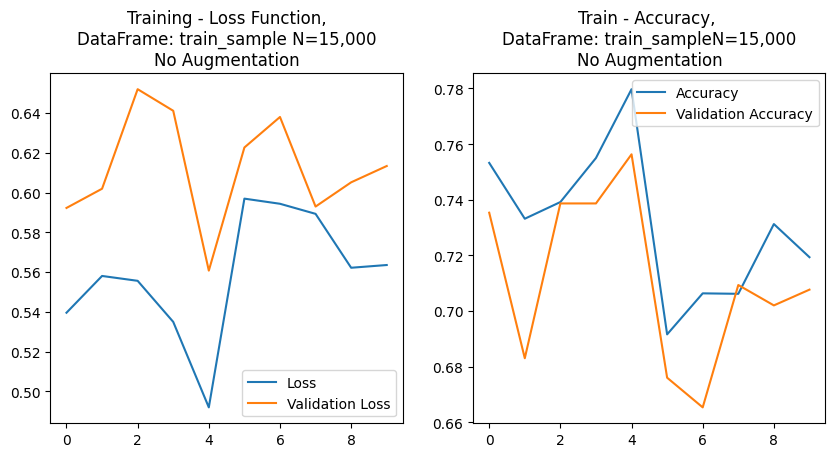

In [84]:
#plot training accuracy vs. loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function,\nDataFrame: train_sample N=15,000\nNo Augmentation')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy, \nDataFrame: train_sampleN=15,000\nNo Augmentation')

The y-interval's increments is .02 on both curves above, so the variation in both the optimization and loss curves is not as stark as it looks. Greater computational power may lead to smoother, less noisy curves for both training and validation. Due to CPU limitations, training was done on a subset of the images. the sample training size was 15,000 with 7500 dog images and 7500 cat images. 

Epoch 4 showed the greatest difference in both loss and accuracy. With only 10 epochs, this difference has a visual impact. At 10 epochs, neither accuracy curve has leveled off nor has either loss curve. More epochs are recommended.

However, The performance gap plotting model accuracy is small, with the greatest difference at epoch 6, being ~0.04, suggesting that overfitting is not a concern and that the model may be a good fit. It is recommended to rerun with more data and greater computational power.

#### CNN classifier with augmentation: rotation & horizontal flip, DataFrame: train_sample

In [56]:
# Model 2: CNN with rotation and horizontal flip augmentation
history_aug = model.fit(train_generator_aug, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs=10, 
                        validation_data=val_generator_aug, validation_steps=val_generator_aug.n//val_generator_aug.batch_size)
model.save('model_aug.keras')

Epoch 1/10
200/200 [==============================] - 175s 875ms/step - loss: 0.6452 - accuracy: 0.6320 - val_loss: 0.6444 - val_accuracy: 0.6150
Epoch 2/10
200/200 [==============================] - 156s 780ms/step - loss: 0.5984 - accuracy: 0.6902 - val_loss: 0.5712 - val_accuracy: 0.7290
Epoch 3/10
200/200 [==============================] - 174s 871ms/step - loss: 0.5827 - accuracy: 0.7060 - val_loss: 0.5845 - val_accuracy: 0.7490
Epoch 4/10
200/200 [==============================] - 160s 802ms/step - loss: 0.5833 - accuracy: 0.7163 - val_loss: 0.6472 - val_accuracy: 0.6213
Epoch 5/10
200/200 [==============================] - 154s 769ms/step - loss: 0.5851 - accuracy: 0.7022 - val_loss: 0.5478 - val_accuracy: 0.7360
Epoch 6/10
200/200 [==============================] - 152s 761ms/step - loss: 0.5815 - accuracy: 0.7082 - val_loss: 0.5679 - val_accuracy: 0.7203
Epoch 7/10
200/200 [==============================] - 154s 770ms/step - loss: 0.5980 - accuracy: 0.6883 - val_loss: 0.5882 -

### Evaluate Model 2: CNN with Augmentation

In [91]:
# Evaluate on Validation data
aug_scores = model.evaluate(val_generator_aug)
print("%s%s: %.2f%%" % ("evaluate: validation ",model.metrics_names[1], aug_scores[1]*100))

50/50 [==============================] - 35s 705ms/step - loss: 0.6086 - accuracy: 0.6847
evaluate validation accuracy: 68.47%


Text(0.5, 1.0, 'Train - Accuracy,\nDataFrame: train_sample N=15,000\nRotational & Horizontal Flip Augmentation')

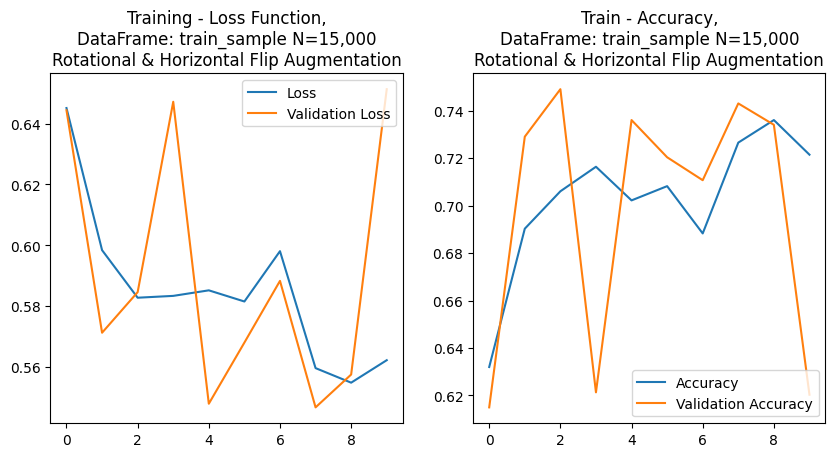

In [87]:
#plot training accuracy vs. loss
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history_aug.history['loss'], label='Loss')
plt.plot(history_aug.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function,\nDataFrame: train_sample N=15,000\nRotational & Horizontal Flip Augmentation')

plt.subplot(2, 2, 2)
plt.plot(history_aug.history['accuracy'], label='Accuracy')
plt.plot(history_aug.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy,\nDataFrame: train_sample N=15,000\nRotational & Horizontal Flip Augmentation')

As in the previous model, the y-interval on both the optimization and performance plots is 0.02 so variation is not as stark it is appears.
However, there is much more noise in both validation curves. There is also no indication of leveling off for either the training or validation curves on either the optimization or performance curves. 

### Predict Test Set

With a validation accuracy of 74.1% and learning curves that suggest possible leveling and less noise than the model with augmentation (val_accuracy = ~ 69.1%), the CNN model with no augmentation will be used to predict the test images. 

In [119]:
#code taken from Doc Larry
test_generator.reset() #you have to do this!
y_pred=model.predict(test_generator,steps=12500,verbose=1) 

12500/12500 [==============================] - 197s 16ms/step


In [132]:
#code taken from Doc Larry

#get the filenames
filenames=test_generator.filenames
#parse filename from path
filenames = [os.path.basename(os.path.normpath(filename)) for filename in filenames]
#strip extension (.jpg) from filename
filenames = [os.path.splitext(filename)[0] for filename in filenames]

results=pd.DataFrame({"id":filenames,"label":np.round(y_pred[:,1],9)})#build a data frame
results.to_csv('data/dogs_vs_cats/dog_cat_results.csv',index=False) 